<a id='top'></a>

# Signal DSP using FFT and psd

This notebook will demonstrate some of the basic aspects related with digital signal processing. It is mostly inspired by two LabVIEW white papers, [this](http://www.ni.com/white-paper/4278/en/) and [this](http://www.ni.com/white-paper/4541/en/). We will also take the oportunity to test different implementations of power spectrum estimation functions from two common Python packages, [matplotlib.mlab](http://matplotlib.org/api/mlab_api.html) and [scipy.signal](https://scipy.github.io/devdocs/signal.html), due to this [StackOverflow question](http://stackoverflow.com/questions/33286467/why-do-the-power-spectral-density-estimates-from-matplotlib-mlab-psd-and-scipy-s).

## Table of contents

[Preamble](#Preamble)

[Introduction](#Introduction)

[Signal](#Signal)

[Matplotlib package](#Matplotlib-package)

[Conclusions](#Conclusions)

[Odds and ends](#Odds-and-ends)

## Preamble

The computational environment set up for this Python notebook includes numpy and scipy for the numerical simulations, matplotlib and pandas for the plots:

In [1]:
import sys
import numpy as np
import scipy as sp
import matplotlib as mpl
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

print(sys.version)
for package in (np, sp, mpl, pd):
    print('{:.<15}{}'.format(package.__name__, package.__version__))

3.5.2 |Anaconda custom (32-bit)| (default, Jul  2 2016, 17:49:02) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
numpy..........1.11.2
scipy..........0.18.1
matplotlib.....1.5.3
pandas.........0.19.1


Furthermore, we will need the following special functions:

In [2]:
from numpy.fft import fft, fftfreq, rfft, rfftfreq, fftshift
from scipy.signal import periodogram, welch
from matplotlib.mlab import rms_flat, psd, detrend_none, window_hanning

[Back to top](#top)

## Introduction

The power spectral density can be estimated in a few different ways using:

1. The [periodogram](https://en.wikipedia.org/wiki/Periodogram)
2. The [Bartlett's method](https://en.wikipedia.org/wiki/Bartlett%27s_method)
3. The [Welch's method](https://en.wikipedia.org/wiki/Welch%27s_method)

[Back to top](#top)

## Signal

For the purpose of illustration, in this notebook will be used a signal composed of a small amplitude sine wave masked by a large amplitude random noise:

                Max       Min      Mean       RMS
Noise      0.499650 -0.497811  0.019811  0.294263
Sine wave  0.199999 -0.199999  0.001030  0.141467
Signal     0.674405 -0.685897  0.020841  0.324991


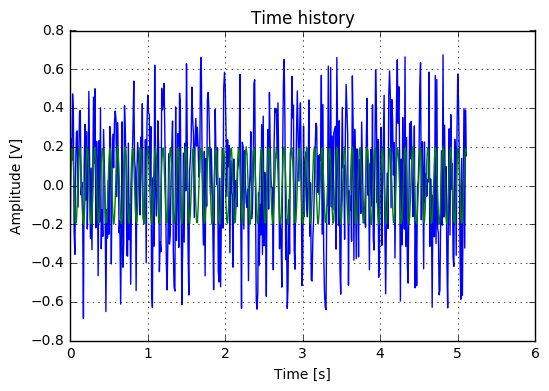

In [3]:
np.random.seed(1234)
f = 10.24
w = 2*np.pi*f
Fs = 100
dt = 1./Fs
Ns = 512
A = 0.2
t = np.arange(Ns)*dt
n = np.random.random(Ns)-0.5
s = A*np.sin(w*t)
x = s+n

v = [(np.max(v), np.min(v), np.mean(v), rms_flat(v)) for v in (n, s, x)]
df = pd.DataFrame(data=v, index=('Noise', 'Sine wave', 'Signal'), columns=('Max', 'Min', 'Mean', 'RMS'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
ax.plot(t, x)
ax.plot(t, s)
ax.set_title('Time history')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude [V]')
ax.grid(True)

As we can see, the RMS of the sine wave (s) is equal to its amplitude (A) divided by the square root of 2 ($RMS(s) = \frac{A}{\sqrt 2}$):

In [4]:
print(A/np.sqrt(2))

0.141421356237


We will start processing this signal by taking its Fourier transform into the frequency domain. Since the signal is real, the result of this transform is Hermitian. For that reason, we will use the rfft function which gives us only the spectral components from 0Hz up to the Nyquist frequency (the first half of the spectrum):

                Max       Freq
Noise      0.034054  16.015625
Sine wave  0.072531  10.156250
Signal     0.068864  10.156250


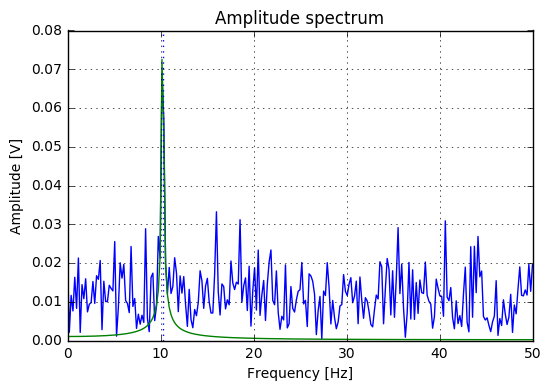

In [5]:
N = rfft(n)/Ns
S = rfft(s)/Ns
X = rfft(x)/Ns
freqs = rfftfreq(x.size, d=1./Fs)

v = [(np.absolute(v[ix]), freqs[ix]) for v in (N, S, X) for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=('Noise', 'Sine wave', 'Signal'), columns=('Max', 'Freq'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
ax.plot(freqs, np.absolute(X))
ax.plot(freqs, np.absolute(S))
ax.axvline(f, ls=':')
ax.set_title('Amplitude spectrum')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [V]')
ax.grid(True)
plt.show()

The division of the FFT by the number of samples (Ns) was necessary in order to use it directly in the estimation of the signal power spectrum:

                Max       Freq
Noise      0.001160  16.015625
Sine wave  0.005261  10.156250
Signal     0.004742  10.156250


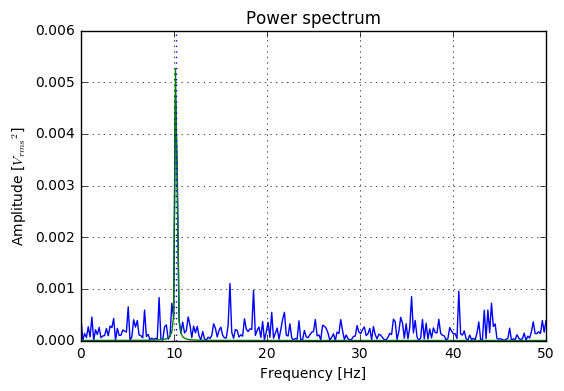

In [6]:
Pnn = np.real(N*np.conj(N))
Pss = np.real(S*np.conj(S))
Pxx = np.real(X*np.conj(X))

v = [(v[ix], freqs[ix]) for v in (Pnn, Pss, Pxx) for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=('Noise', 'Sine wave', 'Signal'), columns=('Max', 'Freq'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
ax.plot(freqs, Pxx)
ax.plot(freqs, Pss)
ax.axvline(f, ls=':')
ax.set_title('Power spectrum')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [${V_{rms}}^2$]')
ax.grid(True)
plt.show()

This could be achieved by using directly the periodogram function:

                Max       Freq
Noise      0.002319  16.015625
Sine wave  0.010522  10.156250
Signal     0.009485  10.156250


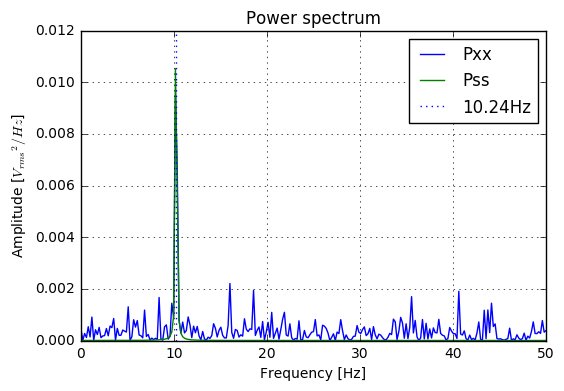

In [7]:
freqs, Pnn = periodogram(n, fs=Fs, window=None, nfft=None, detrend=None, return_onesided=True, scaling='spectrum')
freqs, Pss = periodogram(s, fs=Fs, window=None, nfft=None, detrend=None, return_onesided=True, scaling='spectrum')
freqs, Pxx = periodogram(x, fs=Fs, window=None, nfft=None, detrend=None, return_onesided=True, scaling='spectrum')

v = [(np.absolute(v[ix]), freqs[ix]) for v in (Pnn, Pss, Pxx) for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=('Noise', 'Sine wave', 'Signal'), columns=('Max', 'Freq'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
ax.plot(freqs, Pxx, label='Pxx')
ax.plot(freqs, Pss, label='Pss')
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('Power spectrum')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [${V_{rms}}^2/Hz$]')
ax.legend()
ax.grid(True)
plt.show()

The peak of the Pss estimated by the periodogram function is the double of the Pss estimated through the FFT of the signal because it was computed as a one-sided spectrum instead of a two-sided spectrum as it would have been achieved using the FFT:

In [8]:
print(df['Max']['Sine wave']/2)

0.00526076689053


More important than the power spectrum is, in our case, the power spectral density of the signal:

                Max       Freq
Noise      0.011875  16.015625
Sine wave  0.053870  10.156250
Signal     0.048561  10.156250


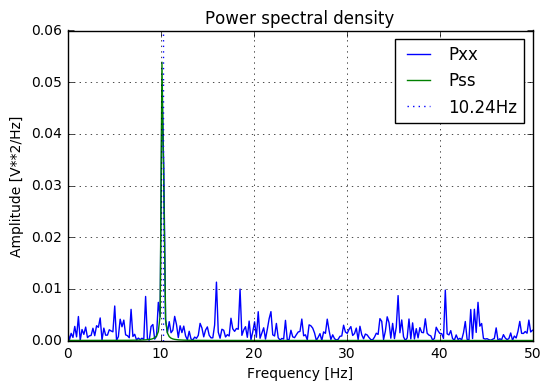

In [9]:
freqs, Pnn = periodogram(n, fs=Fs, window=None, nfft=None, detrend=None, return_onesided=True, scaling='density')
freqs, Pss = periodogram(s, fs=Fs, window=None, nfft=None, detrend=None, return_onesided=True, scaling='density')
freqs, Pxx = periodogram(x, fs=Fs, window=None, nfft=None, detrend=None, return_onesided=True, scaling='density')

v = [(np.absolute(v[ix]), freqs[ix]) for v in (Pnn, Pss, Pxx) for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=('Noise', 'Sine wave', 'Signal'), columns=('Max', 'Freq'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
ax.plot(freqs, Pxx, label='Pxx')
ax.plot(freqs, Pss, label='Pss')
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('Power spectral density')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [V**2/Hz]')
ax.legend()
ax.grid(True)
plt.show()

Naturally, the peak power spectrum can be estimated from the power spectral density by multiplying by the frequency discretisation:

In [10]:
print(df['Max']['Sine wave']/2*(freqs[1]-freqs[0]))

0.00526076689053


[Back to top](#top)

## Matplotlib package

Matplotlib supplies one function, [psd](http://matplotlib.org/api/mlab_api.html#matplotlib.mlab.psd), to estimate the power spectral density (Pxx) of a signal (x) in the [mlab](http://matplotlib.org/api/mlab_api.html) module. This function, which is described as a "Welch’s average periodogram method", has the following signature:

    matplotlib.mlab.psd(x, NFFT=256, Fs=2, detrend=mlab.detrend_none, window=mlab.window_hanning, noverlap=0, pad_to=None,sides='default', scale_by_freq=None)

The function returns a tuple with the power spectral density estimate and the corresponding frequencies (Pxx, freqs).

                Max      Freq
Noise      0.008181  43.75000
Sine wave  0.032052  10.15625
Signal     0.028819  10.15625


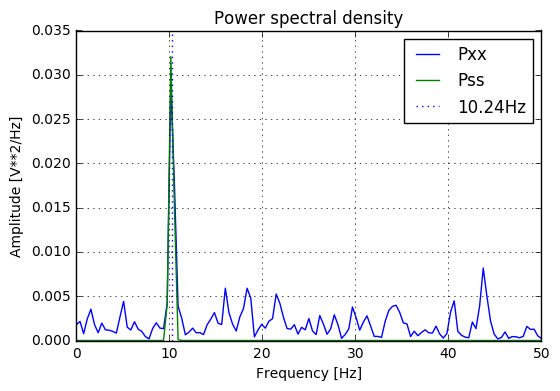

In [11]:
Pnn, freqs = psd(n, NFFT=256, Fs=Fs, detrend=detrend_none, window=window_hanning, noverlap=0, pad_to=None,
                 sides='onesided', scale_by_freq=True)
Pss, freqs = psd(s, NFFT=256, Fs=Fs, detrend=detrend_none, window=window_hanning, noverlap=0, pad_to=None,
                 sides='onesided', scale_by_freq=True)
Pxx, freqs = psd(x, NFFT=256, Fs=Fs, detrend=detrend_none, window=window_hanning, noverlap=0, pad_to=None,
                 sides='onesided', scale_by_freq=True)

v = [(np.absolute(v[ix]), freqs[ix]) for v in (Pnn, Pss, Pxx) for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=('Noise', 'Sine wave', 'Signal'), columns=('Max', 'Freq'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
ax.plot(freqs, Pxx, label='Pxx')
ax.plot(freqs, Pss, label='Pss')
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('Power spectral density')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [V**2/Hz]')
ax.legend()
ax.grid(True)
plt.show()

[Back to top](#top)

## SciPy package

SciPy supplies two functions to estimate the power spectral density (Pxx) of a signal (x) in the [signal](https://scipy.github.io/devdocs/signal.html) module, [periodogram](https://scipy.github.io/devdocs/generated/scipy.signal.periodogram.html) and [welch](https://scipy.github.io/devdocs/generated/scipy.signal.welch.html). Their signatures are the following:

    scipy.signal.periodogram(x, fs=1.0, window=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)

    scipy.signal.welch(x, fs=1.0, window='hann', nperseg=256, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)

The first function uses a periodogram whereas the second function uses the Welch’s method. In the particular case that noverlap is 0, this method is equivalent to Bartlett’s method. Both functions return a tuple with the frequencies and the power spectral density estimate (freqs, Pxx).

                Max      Freq
Noise      0.011338  43.75000
Sine wave  0.032163  10.15625
Signal     0.036049  10.15625


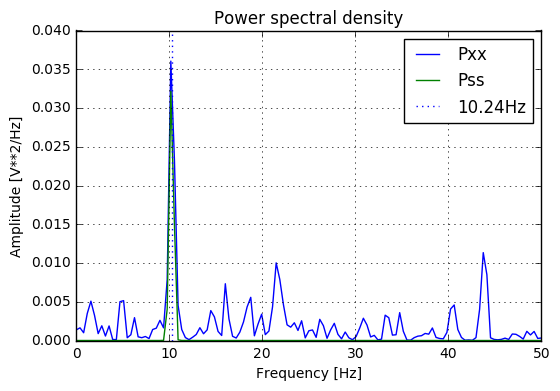

In [12]:
freqs, Pnn = periodogram(n, fs=Fs, window='hann', nfft=256, detrend=None,
                         return_onesided=True, scaling='density', axis=-1)
freqs, Pss = periodogram(s, fs=Fs, window='hann', nfft=256, detrend=None,
                         return_onesided=True, scaling='density', axis=-1)
freqs, Pxx = periodogram(x, fs=Fs, window='hann', nfft=256, detrend=None,
                         return_onesided=True, scaling='density', axis=-1)

v = [(np.absolute(v[ix]), freqs[ix]) for v in (Pnn, Pss, Pxx) for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=('Noise', 'Sine wave', 'Signal'), columns=('Max', 'Freq'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
ax.plot(freqs, Pxx, label='Pxx')
ax.plot(freqs, Pss, label='Pss')
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('Power spectral density')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [V**2/Hz]')
ax.legend()
ax.grid(True)
plt.show()

                Max       Freq
Noise      0.006205  18.359375
Sine wave  0.032163  10.156250
Signal     0.031526  10.156250


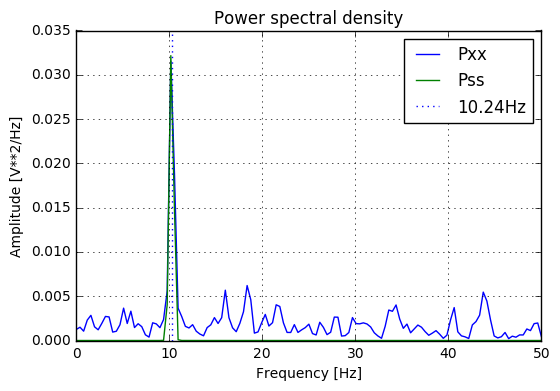

In [13]:
freqs, Pnn = welch(n, fs=Fs, window='hann', nperseg=256, noverlap=None, nfft=None, detrend=None,
                   return_onesided=True, scaling='density', axis=-1)
freqs, Pss = welch(s, fs=Fs, window='hann', nperseg=256, noverlap=None, nfft=None, detrend=None,
                   return_onesided=True, scaling='density', axis=-1)
freqs, Pxx = welch(x, fs=Fs, window='hann', nperseg=256, noverlap=None, nfft=None, detrend=None,
                   return_onesided=True, scaling='density', axis=-1)

v = [(np.absolute(v[ix]), freqs[ix]) for v in (Pnn, Pss, Pxx) for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=('Noise', 'Sine wave', 'Signal'), columns=('Max', 'Freq'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
ax.plot(freqs, Pxx, label='Pxx')
ax.plot(freqs, Pss, label='Pss')
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('Power spectral density')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [V**2/Hz]')
ax.legend()
ax.grid(True)
plt.show()

[Back to top](#top)

## References

P. Welch, “The use of the fast Fourier transform for the estimation of power spectra: A method based on time averaging over short, modified periodograms”, IEEE Trans. Audio Electroacoust. vol. 15, pp. 70-73, 1967.

[Back to top](#top)

## Odds and ends

This notebook was created by Paulo Xavier Candeias.

[Back to top](#top)